In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import SparsePCA, PCA
import matplotlib.pyplot as plt
from amacrine_color_schema import *

Connecting sstrauss@172.25.240.205:3306


Load data

In [2]:
X = pd.read_pickle('Data/BCs/Dataframes/control_data.pkl')

Perform sparse PCA on chirps

global_chirp
(3589, 331)
local_chirp
(3589, 331)


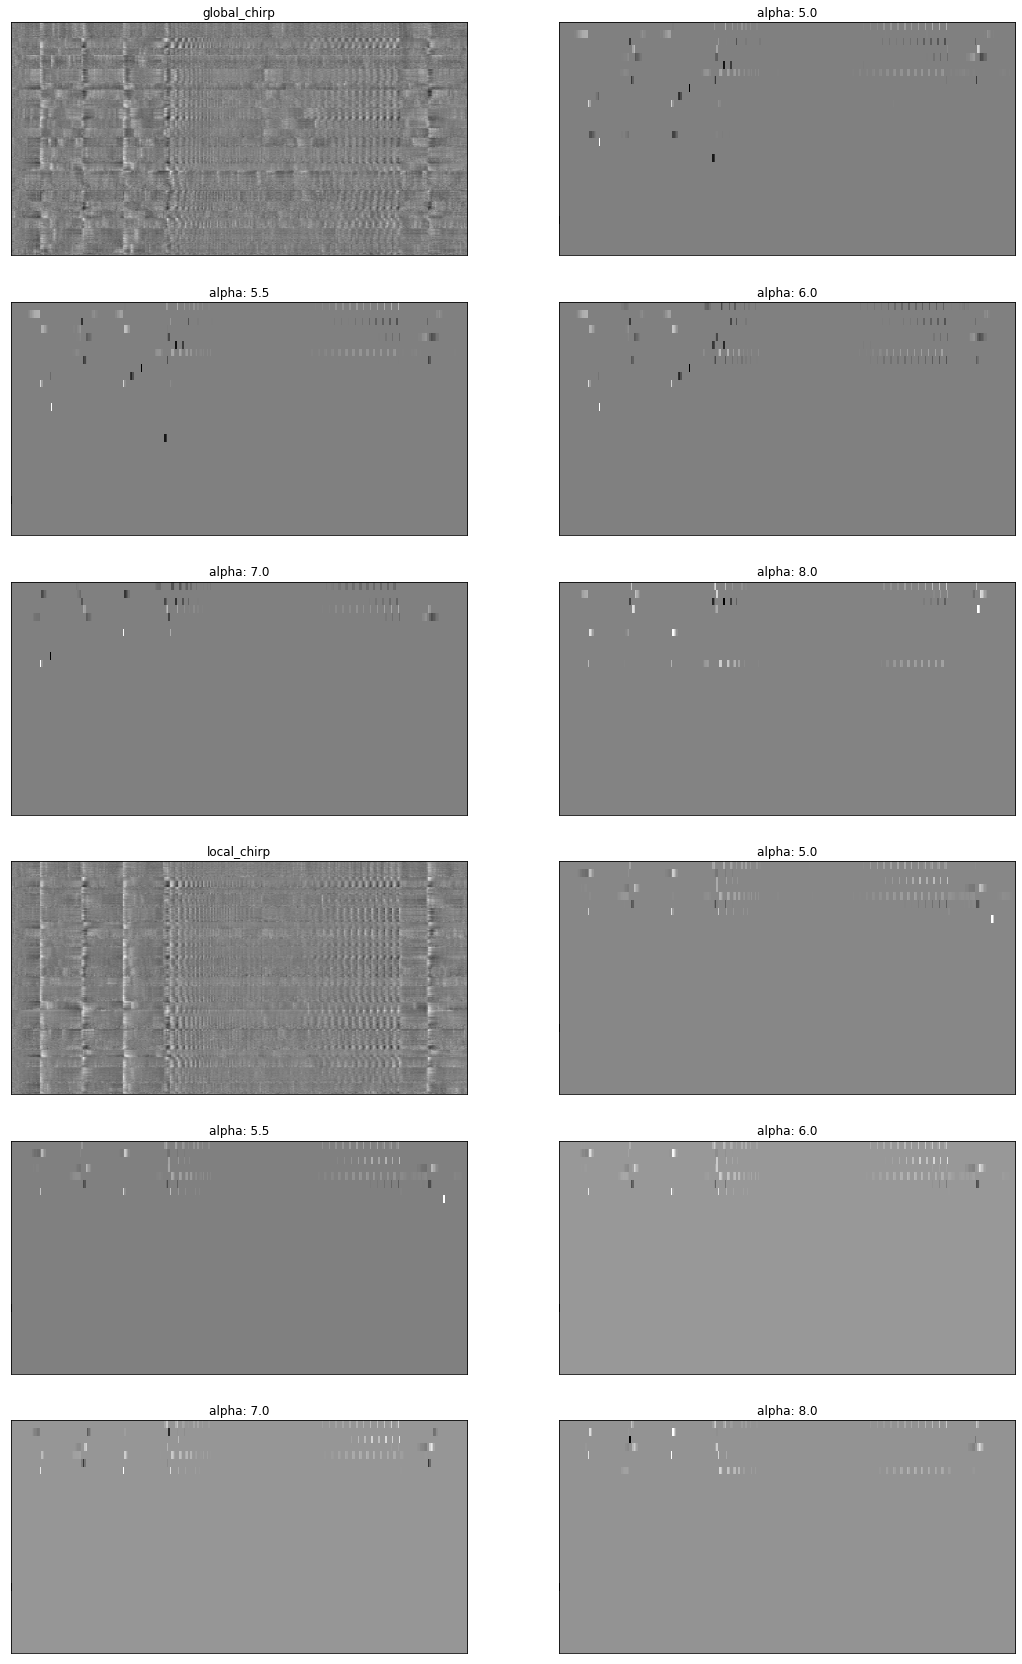

In [3]:
labels = ['global_chirp', 'local_chirp']
nb_components = 30
alpha_values = np.array([5, 5.5, 6, 7, 8])

plotting_idx = 1
plt.figure(figsize=(18,30))

for current_label in labels:
    print(current_label)
    current_data = np.vstack(X[current_label].to_numpy())
    print(current_data.shape)
    
    plt.subplot(6, 2, plotting_idx)
    plt.imshow(current_data, aspect = 'auto', cmap = 'binary_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(current_label)
    plotting_idx = plotting_idx + 1

    for current_alpha in alpha_values:
        pca = SparsePCA(n_components = nb_components, alpha = current_alpha, random_state = 0)
        pca.fit(current_data)
        
        plt.subplot(6, 2, plotting_idx)
        plt.imshow(pca.components_, aspect = 'auto', cmap = 'binary_r', interpolation = 'None')
        plt.xticks([])
        plt.yticks([])
        plt.title('alpha: ' + str(current_alpha))
        plotting_idx = plotting_idx + 1

plt.show()

Perform final PCA

In [4]:
for index, current_label in enumerate(labels):

    current_data = np.vstack(X[current_label].to_numpy())
    pca = SparsePCA(n_components = nb_components, alpha = 6, random_state = 0)
    transformed_X = pca.fit_transform(current_data)
    X[current_label + ' sPCA full'] = list(transformed_X)

Remove zero components

In [5]:
for index, current_label in enumerate(labels):
    print(current_label)
    current_data = np.vstack(X[current_label + ' sPCA full'].to_numpy())
    indices = np.where((current_data != 0).sum(axis = 0) != 0)[0]
    print(indices)
    new_data = current_data[:,indices]
    X[current_label + ' sPCA'] = list(new_data)

global_chirp
[ 0  1  2  3  4  5  6  7  8  9 10 13]
local_chirp
[ 0  1  2  3  4  5  6 21]


PCA on kernels w 3 components

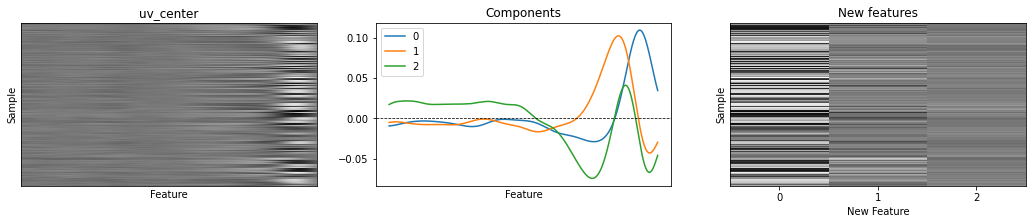

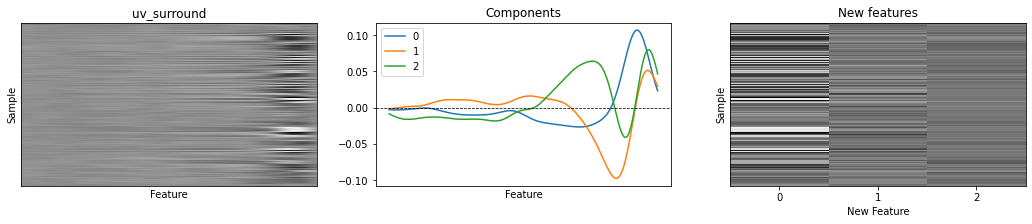

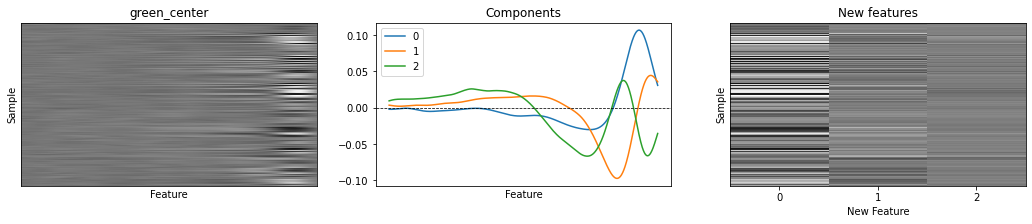

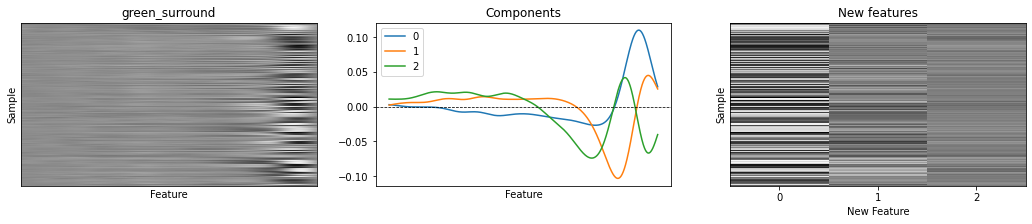

In [6]:
labels = ['uv_center', 'uv_surround', 'green_center', 'green_surround']
len_kernel = 1250
assert len(X['uv_center'].iloc[0]) == len_kernel
stop_kernel = int(len_kernel*3/4)
start_kernel = (MinMaxQualityParams() & 'param_id = 2').fetch1('start_kernel')
kernel_threshold = 0.1

for current_label in labels:
    current_data = np.vstack(X[current_label].to_numpy())[:,0:stop_kernel]
    
    plt.figure(figsize=(18,3))
    plt.subplot(1,3,1)
    plt.imshow(current_data, aspect = 'auto', cmap = 'binary_r', interpolation = 'None')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Feature')
    plt.ylabel('Sample')
    plt.title(current_label)
    
    pca = PCA(n_components=3, random_state=0)
    X_transformed = pca.fit_transform(current_data)
    X[current_label + ' PCA'] = list(X_transformed)
    X[current_label + ' polarity'] = list((X_transformed[:,0]>0)*1)
        
    min_ = np.amin(current_data[:,start_kernel:], axis=1)
    max_ = np.amax(current_data[:,start_kernel:], axis=1)
       
    # Calculate kernel amplitude
    amplitude = np.abs(max_ - min_)
    X[current_label + ' quality'] = list((amplitude>kernel_threshold)*1)
    sign = np.ones(len(X))
    off_rois = np.where(X[current_label + ' polarity'].to_numpy() == 0)[0]
    sign[off_rois] = -1
    X[current_label + ' amplitude'] = amplitude*sign
    
    plt.subplot(1,3,2)
    plt.plot(pca.components_[0,:], label = '0')
    plt.plot(pca.components_[1,:], label = '1')
    plt.plot(pca.components_[2,:], label = '2')
    plt.axhline(0, color = 'black', linestyle = 'dashed', linewidth = 0.75)
    plt.legend()
    plt.xlabel('Feature')
    plt.title('Components')
    plt.xticks([])

    plt.subplot(1,3,3)
    plt.imshow(X_transformed, aspect = 'auto', cmap = 'binary_r', interpolation = 'None')
    plt.xlabel('New Feature')
    plt.ylabel('Sample')
    plt.title('New features')
    plt.xticks([0,1,2])
    plt.yticks([])
    plt.show()

Combine color features and drop unnecessary columns

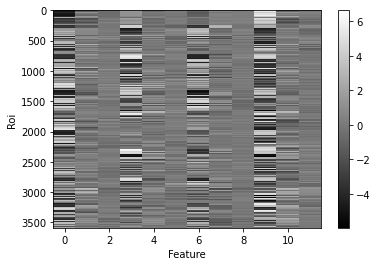

Total number of features: 12


In [7]:
pca_Features = np.concatenate((np.vstack(X['uv_center PCA'].to_numpy()),
                               np.vstack(X['uv_surround PCA'].to_numpy()),
                               np.vstack(X['green_center PCA'].to_numpy()),
                               np.vstack(X['green_surround PCA'].to_numpy())), axis = 1)

plt.imshow(pca_Features, aspect = 'auto', cmap = 'binary_r', interpolation = 'None')
plt.ylabel('Roi')
plt.xlabel('Feature')
plt.colorbar()
plt.show()

print('Total number of features: ' + str(pca_Features.shape[1]))
X['pca features color - 3 components'] = list(pca_Features)

X = X.drop(['uv_center PCA', 
            'uv_surround PCA',
            'green_center PCA', 
            'green_surround PCA'], axis=1)

PCA on kernels w 2 components

In [8]:
for current_label in labels:
    current_data = np.vstack(X[current_label].to_numpy())[:,0:stop_kernel]
    pca = PCA(n_components=2, random_state=0)
    X_transformed = pca.fit_transform(current_data)
    X[current_label + ' PCA'] = list(X_transformed)

Combine color features and drop unnecessary columns

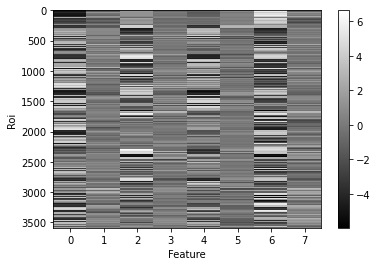

Total number of features: 8


In [9]:
pca_Features = np.concatenate((np.vstack(X['uv_center PCA'].to_numpy()),
                               np.vstack(X['uv_surround PCA'].to_numpy()),
                               np.vstack(X['green_center PCA'].to_numpy()),
                               np.vstack(X['green_surround PCA'].to_numpy())), axis = 1)

plt.imshow(pca_Features, aspect = 'auto', cmap = 'binary_r', interpolation = 'None')
plt.ylabel('Roi')
plt.xlabel('Feature')
plt.colorbar()
plt.show()

print('Total number of features: ' + str(pca_Features.shape[1]))
X['pca features color - 2 components'] = list(pca_Features)

X = X.drop(['uv_center PCA', 
            'uv_surround PCA',
            'green_center PCA', 
            'green_surround PCA'], axis=1)

Save dataframe

In [10]:
#X.to_pickle('Data/BCs/Dataframes/control_data_features.pkl')

Plot polarity examples

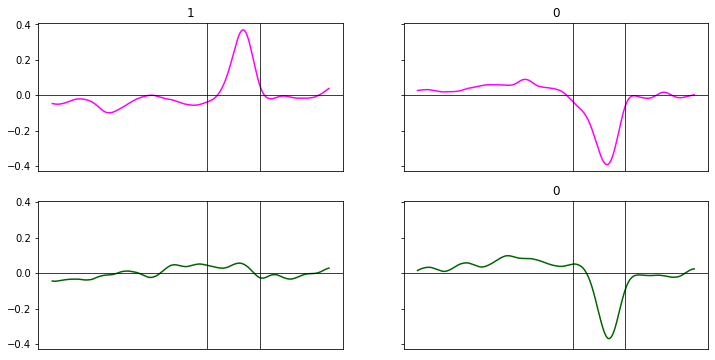

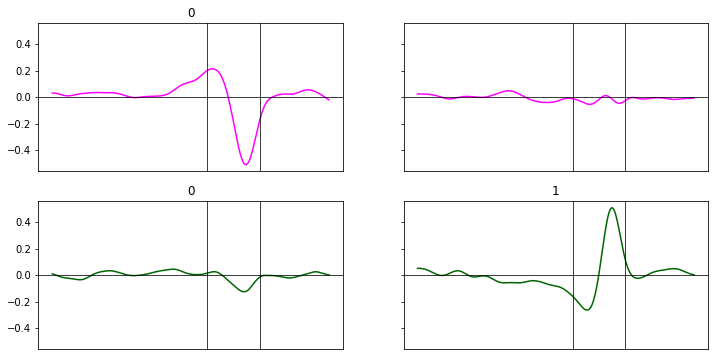

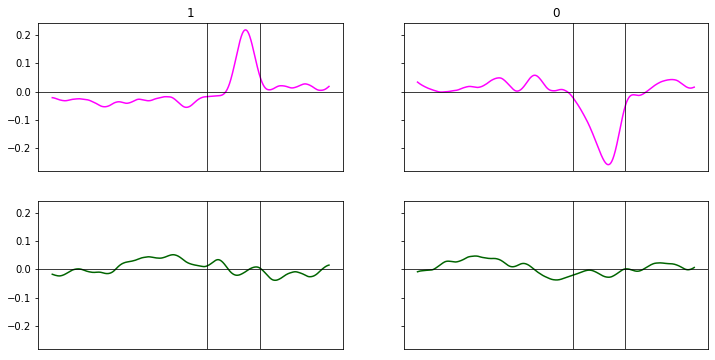

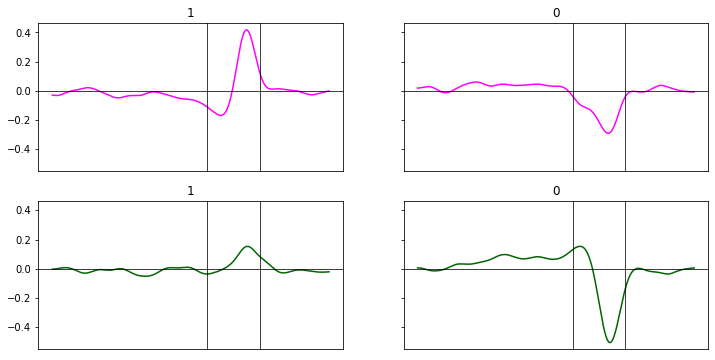

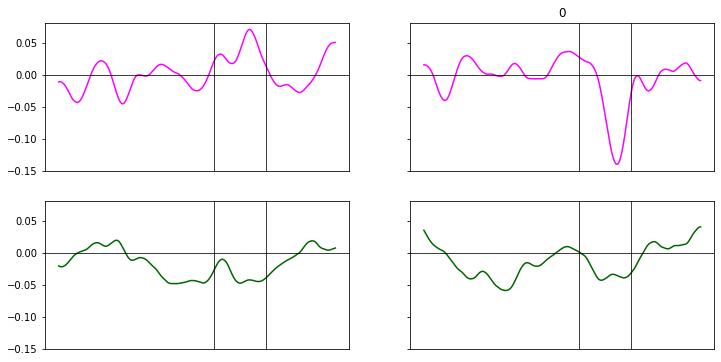

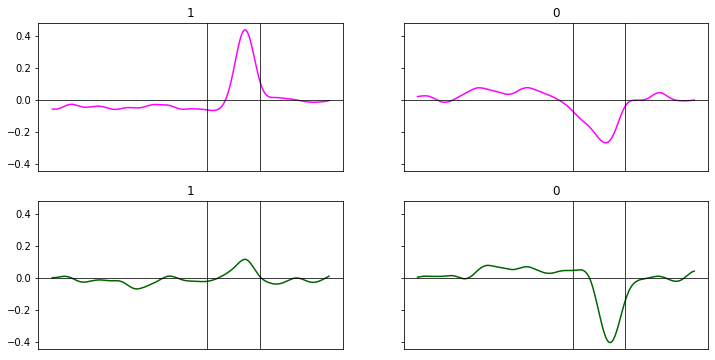

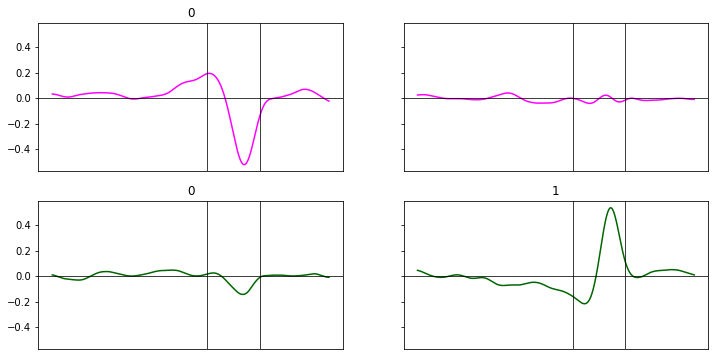

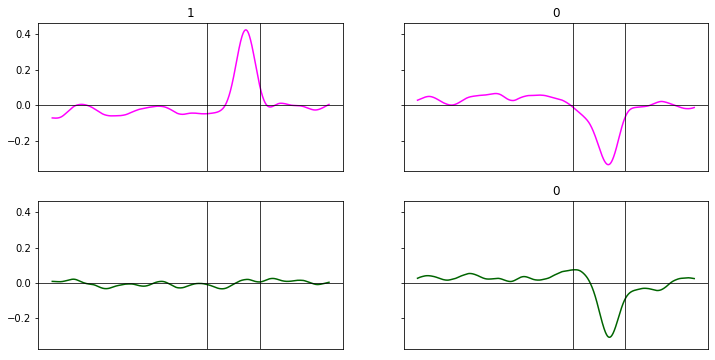

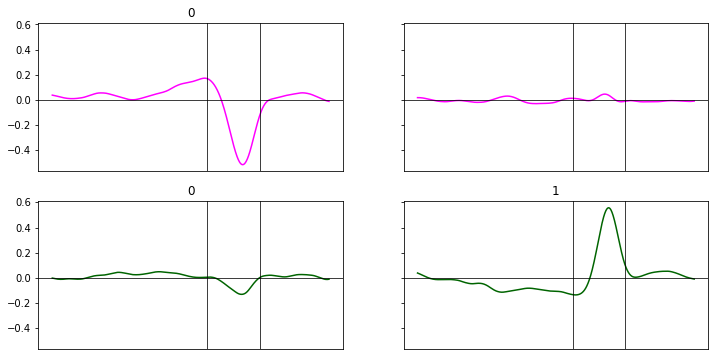

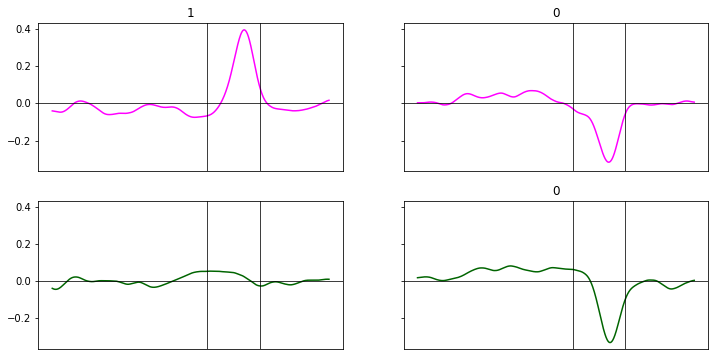

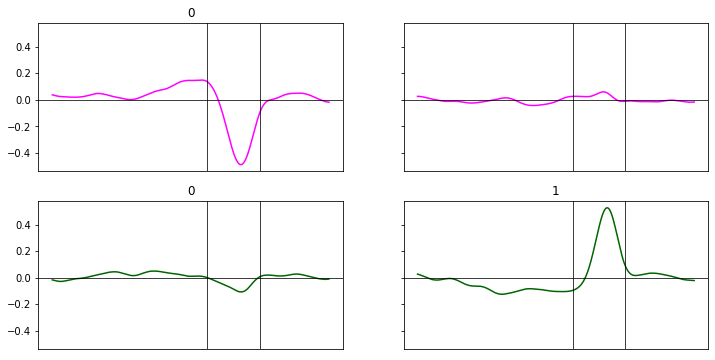

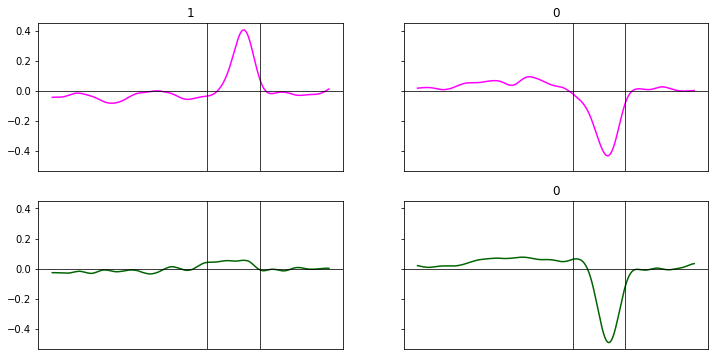

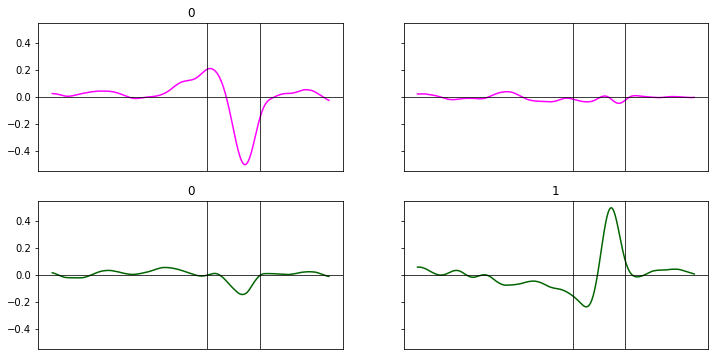

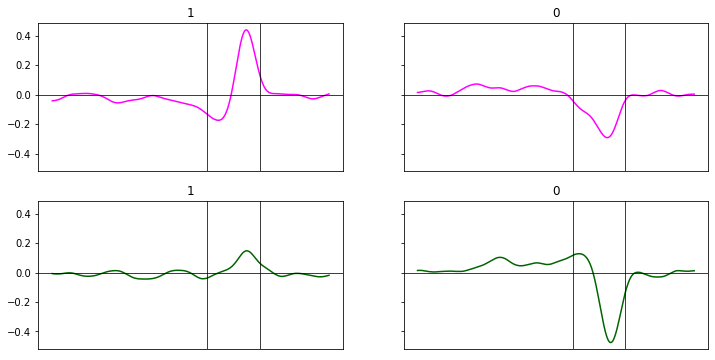

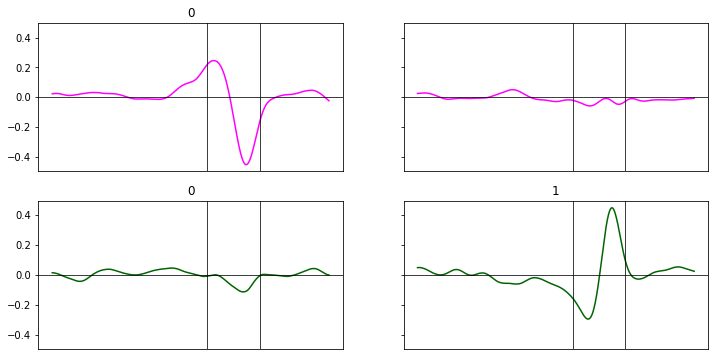

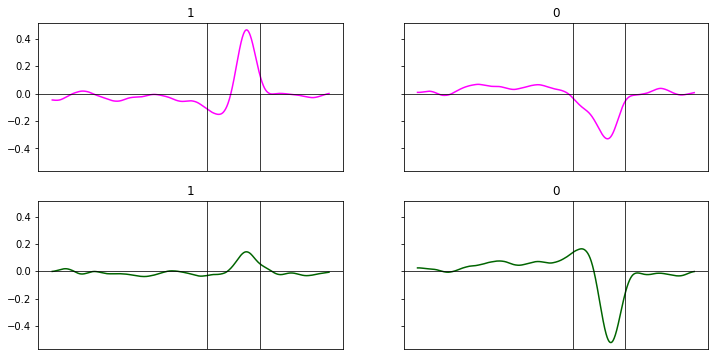

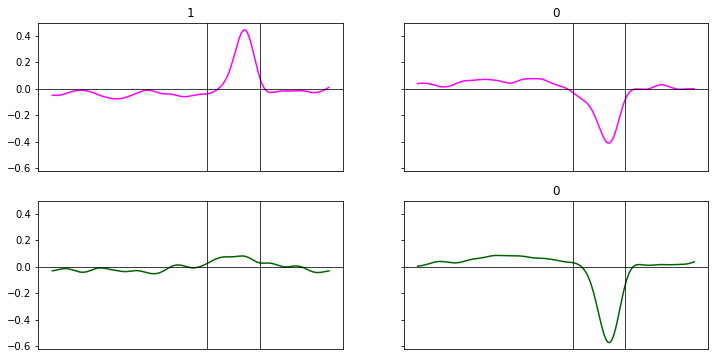

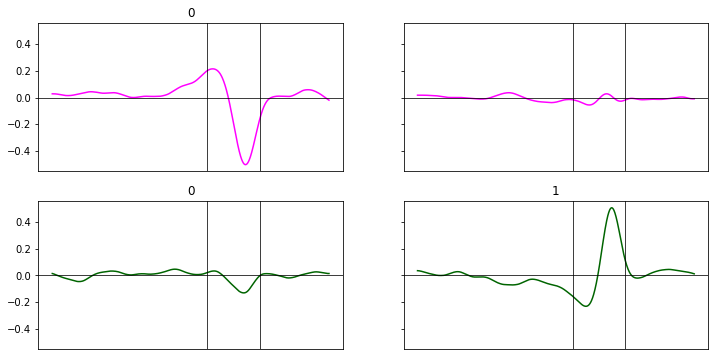

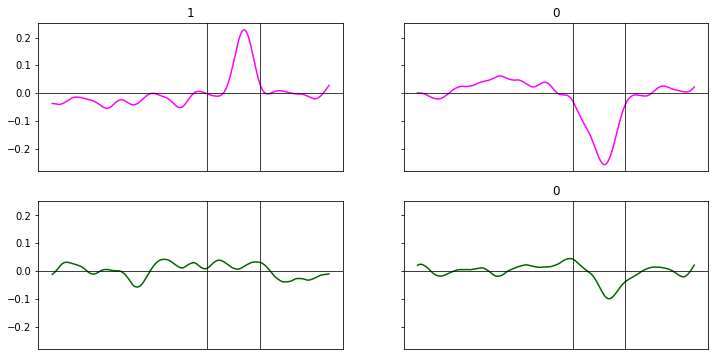

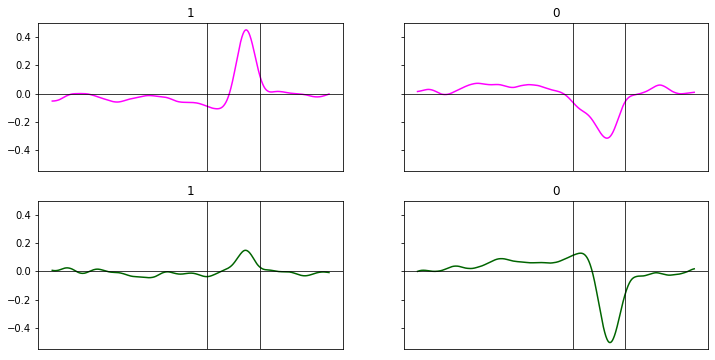

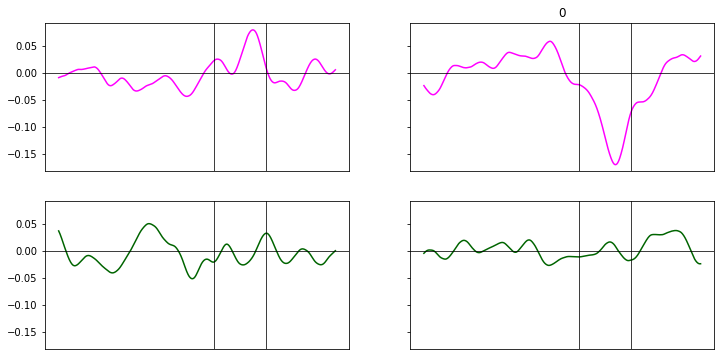

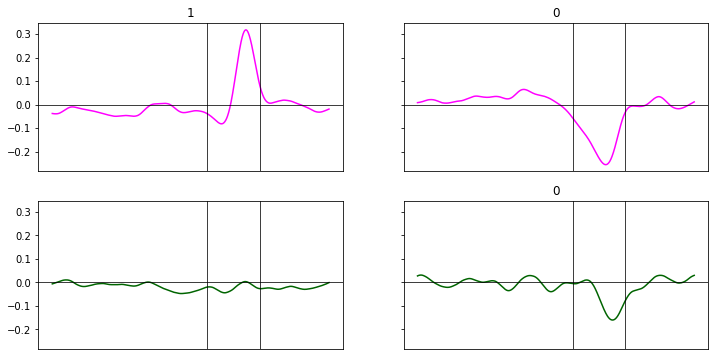

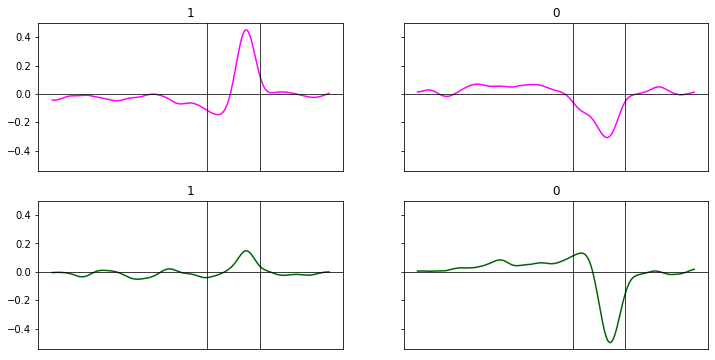

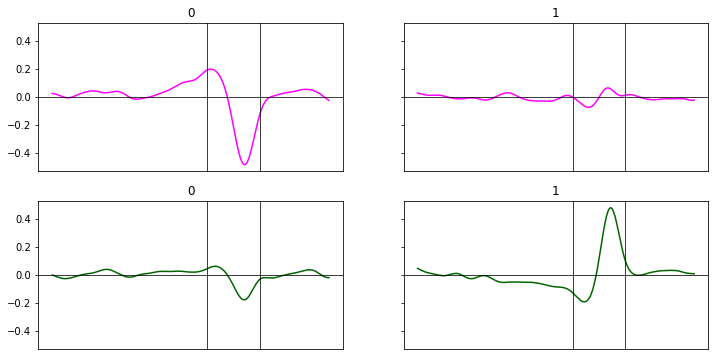

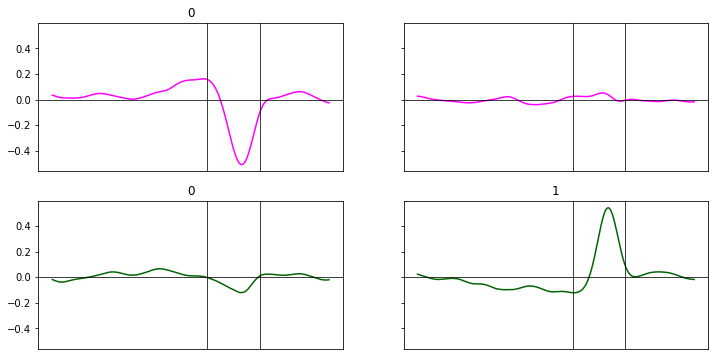

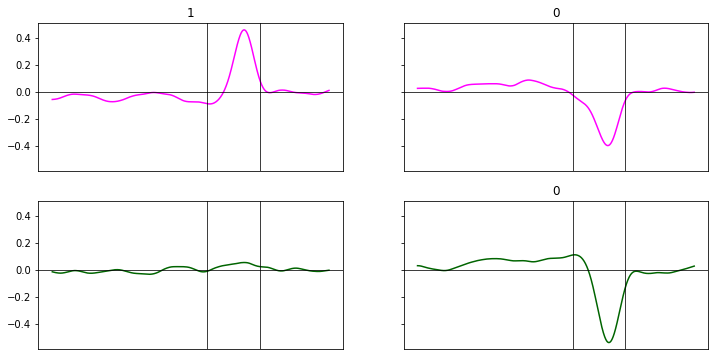

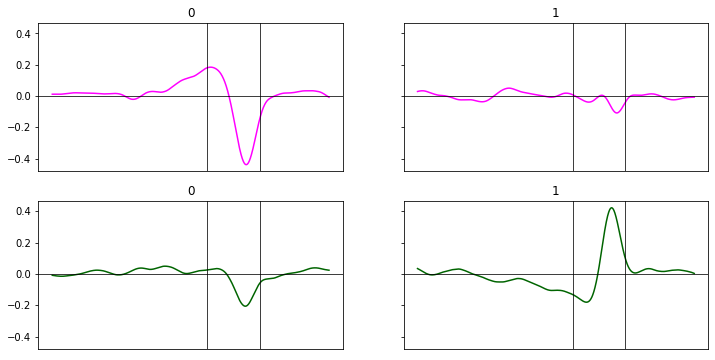

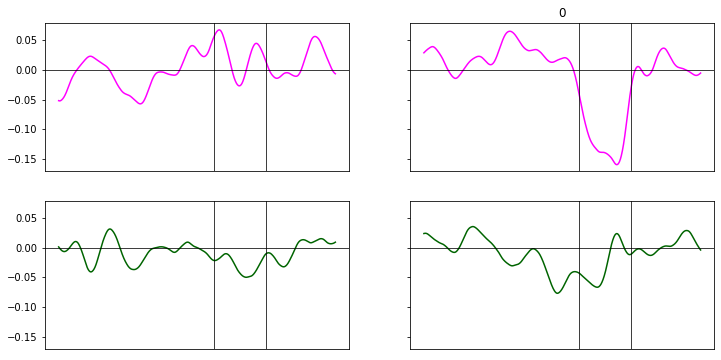

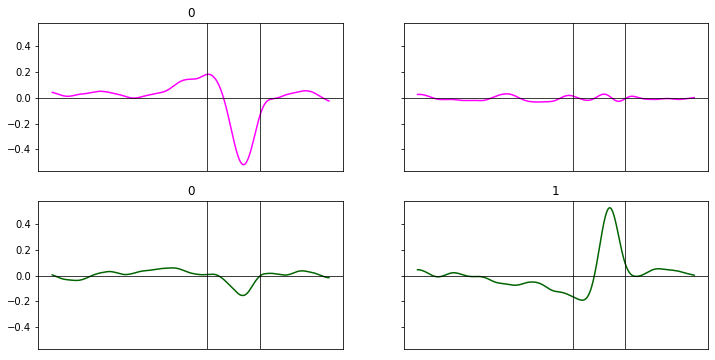

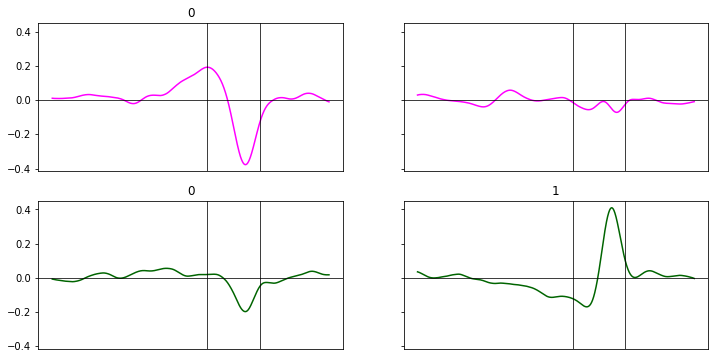

In [11]:
for roi in range(0,30):
    fig, ax = plt.subplots(2,2, figsize=(12,6), sharey = 'all')
    for index, label in enumerate(labels[0:2]):
        ax[0,index].plot(X[label].iloc[roi], color = 'magenta')
        if X[label + ' quality'].iloc[roi]:
             ax[0,index].set_title(X[label + ' polarity'].iloc[roi])
        ax[0,index].axvline(stop_kernel, color = 'black', linewidth = 0.75)
        ax[0,index].axvline(start_kernel, color = 'black', linewidth = 0.75)
        ax[0,index].axhline(0, color = 'black', linewidth = 0.75)
        ax[0,index].set_xticks([])

    for index, label in enumerate(labels[2:]):
        ax[1,index].plot(X[label].iloc[roi], color = 'darkgreen')
        if X[label + ' quality'].iloc[roi]:
             ax[1,index].set_title(X[label + ' polarity'].iloc[roi])
        ax[1,index].axvline(stop_kernel, color = 'black', linewidth = 0.75)
        ax[1,index].axvline(start_kernel, color = 'black', linewidth = 0.75)
        ax[1,index].axhline(0, color = 'black', linewidth = 0.75)
        ax[1,index].set_xticks([])
    plt.show()